# 📊 Project: Predicting Budget Implementation Bottlenecks in LGAs

## 🎯 Objective
This project aims to use machine learning to predict which local government projects are likely to be **abandoned** or **delayed**, based on features like sector, contractor reliability, project budget, and duration.

## 📦 Dataset Summary
The dataset is synthetic and contains the following fields:
- `LGA`: Name of the Local Government Area
- `Region`: Geopolitical region
- `Sector`: Project sector (e.g., Health, Education)
- `Contractor_ID`: Unique identifier for contractors
- `Contractor_Completed`: Number of completed projects by the contractor
- `Contractor_Abandoned`: Number of abandoned projects
- `Contractor_Score`: Performance score between 0 and 1
- `Amount`: Project budget
- `Duration_Days`: Expected project duration
- `Project_Status`: Target variable (`On Time`, `Delayed`, `Abandoned`)

## 🧠 What We'll Do
- Clean and preprocess the data
- Perform exploratory data analysis (EDA)
- Build a predictive model using pipelines (Random Forest/XGBoost)
- Evaluate model performance
- Export trained model for Streamlit deployment


In [19]:
# Load dataset
import pandas as pd

df = pd.read_csv("LGA_Project_Bottlenecks_Synthetic.csv")
df.head()

,LGA,Region,Sector,Contractor_ID,Contractor_Completed,Contractor_Abandoned,Contractor_Score,Amount,Duration_Days,Project_Status
0,Jos North,South West,Health,C009,4,1,0.60,46885.10,171,On Time
1,Nsukka,North East,Education,C004,4,0,0.80,22051.60,148,Delayed
2,Ilorin,South South,Health,C014,5,1,0.67,17538.23,95,Delayed
3,Bwari,North Central,Health,C007,4,1,0.60,21748.68,162,Delayed
4,Nsukka,South South,Electricity,C001,9,0,0.90,13659.25,245,Abandoned


## 📊 Exploratory Data Analysis (EDA)

We will explore:
- Distribution of project outcomes
- Sector and region patterns
- Contractor reliability vs. delays
- Amount and duration trends by project status


In [22]:
import warnings
warnings.filterwarnings("ignore")

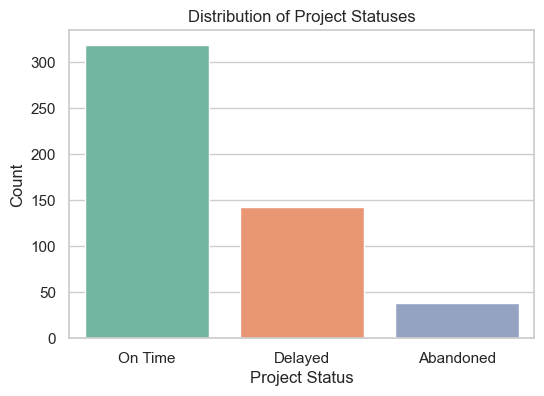

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot distribution of project statuses
plt.figure(figsize=(6,4))
sns.countplot(x="Project_Status", data=df, palette="Set2")
plt.title("Distribution of Project Statuses")
plt.xlabel("Project Status")
plt.ylabel("Count")
plt.show()


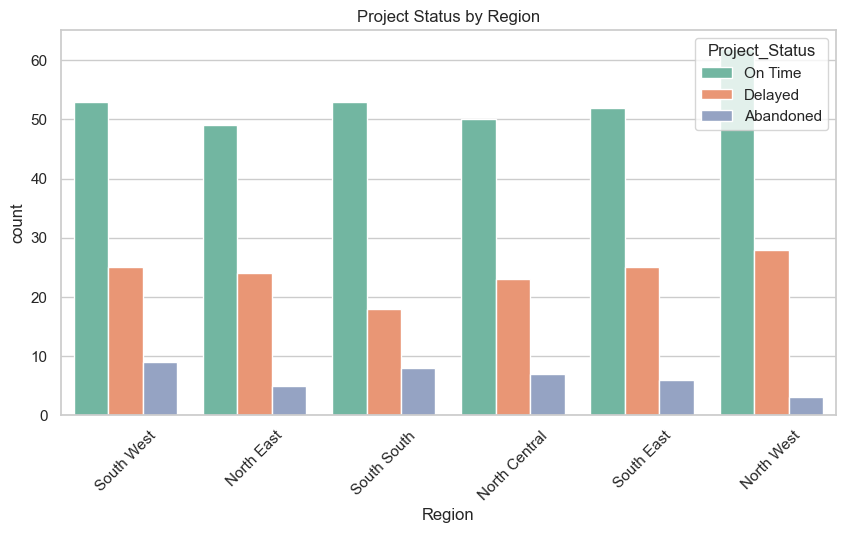

In [24]:
# Project status by region
plt.figure(figsize=(10,5))
sns.countplot(x="Region", hue="Project_Status", data=df, palette="Set2")
plt.title("Project Status by Region")
plt.xticks(rotation=45)
plt.show()


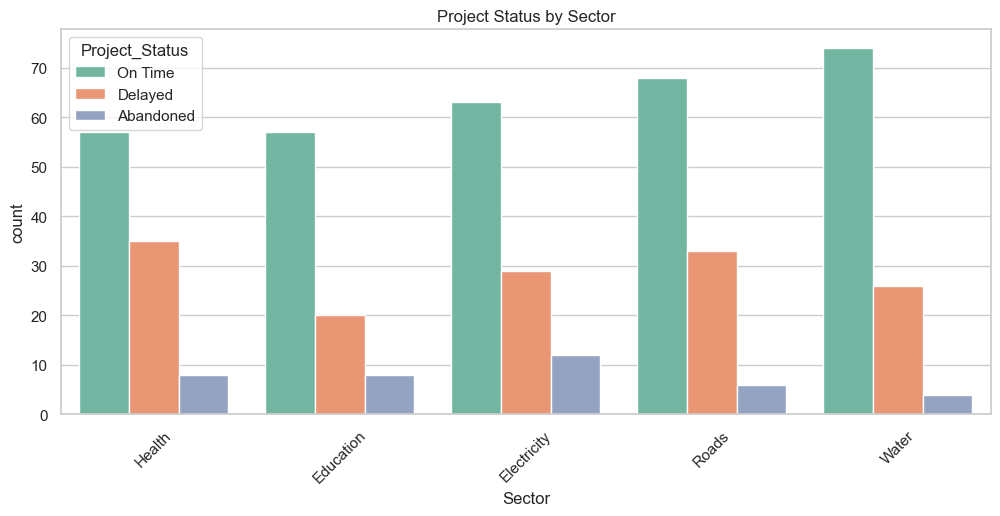

In [25]:
# Project status by sector
plt.figure(figsize=(12,5))
sns.countplot(x="Sector", hue="Project_Status", data=df, palette="Set2")
plt.title("Project Status by Sector")
plt.xticks(rotation=45)
plt.show()


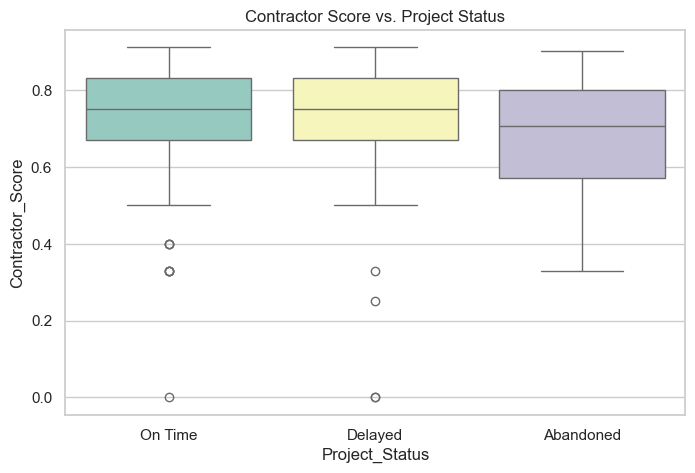

In [26]:
# Relationship between contractor score and project status
plt.figure(figsize=(8,5))
sns.boxplot(x="Project_Status", y="Contractor_Score", data=df, palette="Set3")
plt.title("Contractor Score vs. Project Status")
plt.show()


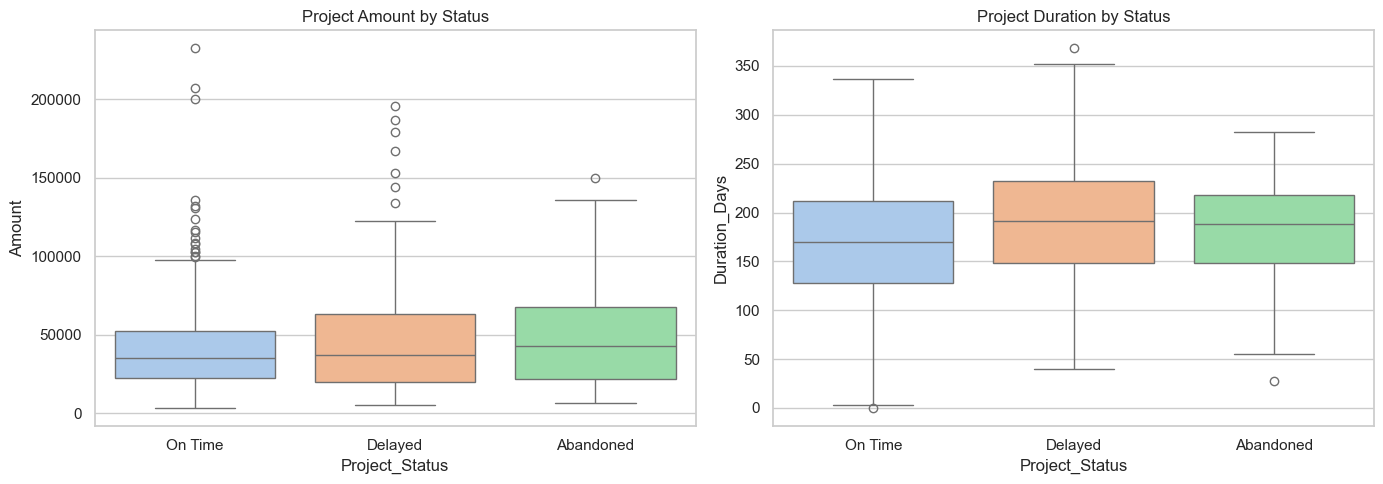

In [27]:
# Budget and duration by status
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(x="Project_Status", y="Amount", data=df, ax=axes[0], palette="pastel")
axes[0].set_title("Project Amount by Status")

sns.boxplot(x="Project_Status", y="Duration_Days", data=df, ax=axes[1], palette="pastel")
axes[1].set_title("Project Duration by Status")
plt.tight_layout()
plt.show()


## 🛠️ Feature Engineering & Target Encoding

We convert the target variable `Project_Status` into a binary classification:
- `High_Risk = 1` if Delayed or Abandoned
- `High_Risk = 0` if On Time

We'll also:
- Drop unnecessary columns
- Use pipelines to handle categorical encoding and scaling


In [28]:
from sklearn.model_selection import train_test_split

# Binary target
df["High_Risk"] = df["Project_Status"].apply(lambda x: 1 if x in ["Delayed", "Abandoned"] else 0)

# Features and target
X = df.drop(columns=["Project_Status", "High_Risk"])
y = df["High_Risk"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.head()


,LGA,Region,Sector,Contractor_ID,Contractor_Completed,Contractor_Abandoned,Contractor_Score,Amount,Duration_Days
113,Owerri,North West,Electricity,C001,5,1,0.67,72624.13,258
204,Ilorin,North West,Electricity,C004,5,0,0.83,43930.60,178
454,Nsukka,South West,Water,C020,6,1,0.71,79598.07,153
66,Nsukka,South East,Education,C016,6,2,0.57,66980.73,145
476,Owerri,South East,Water,C011,8,1,0.78,64858.85,207


In [29]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Categorical and numerical columns
categorical_features = ["LGA", "Region", "Sector", "Contractor_ID"]
numeric_features = ["Contractor_Completed", "Contractor_Abandoned", "Contractor_Score", "Amount", "Duration_Days"]

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("num", StandardScaler(), numeric_features)
])

# Full pipeline with Random Forest
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train model
rf_pipeline.fit(X_train, y_train)

# Predict
y_pred_rf = rf_pipeline.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Accuracy: 0.58
Confusion Matrix:
 [[55  9]
 [33  3]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.86      0.72        64
           1       0.25      0.08      0.12        36

    accuracy                           0.58       100
   macro avg       0.44      0.47      0.42       100
weighted avg       0.49      0.58      0.51       100



In [31]:
from xgboost import XGBClassifier

# XGBoost pipeline
xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Train model
xgb_pipeline.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_pipeline.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))


Accuracy: 0.54
Confusion Matrix:
 [[48 16]
 [30  6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.75      0.68        64
           1       0.27      0.17      0.21        36

    accuracy                           0.54       100
   macro avg       0.44      0.46      0.44       100
weighted avg       0.49      0.54      0.51       100



In [32]:
import joblib

# Save Random Forest model pipeline
joblib.dump(rf_pipeline, "rf_project_risk_model.pkl")

# Save XGBoost model pipeline
joblib.dump(xgb_pipeline, "xgb_project_risk_model.pkl")


['xgb_project_risk_model.pkl']